# Dog/Cat Convolutional Classificator with TensorFlow

## Импорт библиотек

In [1]:
from google.colab import drive
import shutil
import zipfile
import os
import pathlib
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt

tf.test.gpu_device_name()

'/device:GPU:0'

## Подключение GoogleDrive (Для Google Colab)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка набора данных из GoogleDrive

In [3]:
zip_file_path = '/content/drive/MyDrive/Datasets/DogsVsCats.zip'
shutil.copy(zip_file_path, '/content/')

unzip_dir = '/content/DogsVsCats/'
with zipfile.ZipFile('/content/DogsVsCats.zip', 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(os.listdir(unzip_dir))

['MSR-LA - 3467.docx', 'readme[1].txt', 'PetImages']


## Валидация и разбиение данных

In [4]:
def check_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                filepath = os.path.join(root, file)
                try:
                    img_raw = tf.io.read_file(filepath)
                    img = tf.io.decode_image(img_raw, channels=3)
                    img_jpeg = tf.io.encode_jpeg(tf.cast(img, tf.uint8))
                except (tf.errors.InvalidArgumentError, ValueError) as e:
                    print(f"Ошибка с изображением {filepath}: {e}")
                    os.remove(filepath)  # Удаление проблемного изображения


check_images(unzip_dir)

original_dir = pathlib.Path('/content/DogsVsCats/PetImages')
new_base_dir = pathlib.Path('/content/DogsVsCats/preprocessed')


def is_image_valid(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()
            return True
    except (IOError, SyntaxError) as e:
        print(f'Ошибка: {filepath} - {e}')
        return False


def make_subset(subset_name, start_index, end_index):
    for category in ('Cat', 'Dog'):
        directory = new_base_dir / subset_name / category
        os.makedirs(directory, exist_ok=True)
        current_index = start_index
        count = 0

        while count < (end_index - start_index):
            filename = f'{current_index}.jpg'
            src = original_dir / category / filename
            if is_image_valid(src):
                dst = directory / filename
                shutil.copyfile(src, dst)
                count += 1
            current_index += 1
            if current_index > 12500:
                break


make_subset('train', start_index=0, end_index=5000)
make_subset('validation', start_index=5000, end_index=7500)
make_subset('test', start_index=7500, end_index=10000)

Ошибка с изображением /content/DogsVsCats/PetImages/Cat/2663.jpg: {{function_node __wrapped__EncodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} image must be 3-dimensional[1,83,194,3] [Op:EncodeJpeg] name: 
Ошибка с изображением /content/DogsVsCats/PetImages/Cat/9778.jpg: {{function_node __wrapped__EncodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} image must be 3-dimensional[1,342,408,3] [Op:EncodeJpeg] name: 
Ошибка с изображением /content/DogsVsCats/PetImages/Cat/10820.jpg: {{function_node __wrapped__EncodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} image must be 3-dimensional[1,282,288,3] [Op:EncodeJpeg] name: 
Ошибка с изображением /content/DogsVsCats/PetImages/Cat/5553.jpg: {{function_node __wrapped__EncodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} image must be 3-dimensional[1,279,288,3] [Op:EncodeJpeg] name: 
Ошибка с изображением /content/DogsVsCats/PetImages/Cat/11935.jpg: {{function_node __wrapped__EncodeJpeg_device_

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Ошибка: /content/DogsVsCats/PetImages/Dog/9500.jpg - [Errno 2] No such file or directory: '/content/DogsVsCats/PetImages/Dog/9500.jpg'


## Построение модели

Модель будет дообучаться на модели VGG16, обученной на основе набора данных ImageNet.

In [5]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3)
)

conv_base.trainable = False  # Заморозка ранее обученных весов

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 180, 180, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      3,277,056 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

На этапе компиляции используем стандартный оптимизатор `RMSprop`. Так как модель заканчивается единственным сигмоидным выходом, используем функцию потерь `binary_crossentropy`.

In [6]:
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

## Загрузка данных

Для загрузки данных воспользуемся встроенной в Keras функцией `image_dataset_from_directory()`, которая позволит быстро настроить конвейер обработки для автоматического преобразования файлов с изображениями в пакеты готовых тензоров.

In [7]:
train_dataset = keras.utils.image_dataset_from_directory(
    '/content/DogsVsCats/preprocessed/train',
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = keras.utils.image_dataset_from_directory(
    '/content/DogsVsCats/preprocessed/validation',
    image_size=(180, 180),
    batch_size=32
)
test_dataset = keras.utils.image_dataset_from_directory(
    '/content/DogsVsCats/preprocessed/test',
    image_size=(180, 180),
    batch_size=32
)

Found 10000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


## Обучение модели с выделением признаков

Создадим обратный вызов, чтобы автоматически остановить обучение и сохранить лучший вариант модели. Далее обучим модель на ранее подготовленных данных.

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/dogsvscats.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
		patience=10
    )
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 178ms/step - accuracy: 0.9016 - loss: 17.0413 - val_accuracy: 0.9766 - val_loss: 3.0267
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 178ms/step - accuracy: 0.9530 - loss: 5.3009 - val_accuracy: 0.9754 - val_loss: 2.1106
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - accuracy: 0.9553 - loss: 2.8168 - val_accuracy: 0.9730 - val_loss: 1.1654
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 179ms/step - accuracy: 0.9563 - loss: 1.3040 - val_accuracy: 0.9764 - val_loss: 0.6294
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - accuracy: 0.9600 - loss: 0.7030 - val_accuracy: 0.9764 - val_loss: 0.5355
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.9573 - loss: 0.7038 - val_accuracy: 0.9674 - val_loss: 0.6632
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 177ms/step - accuracy: 0.9619 - loss: 0.6600 - val_accuracy: 0.9718 - val_loss: 0.7868
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 184ms/step - accuracy: 0.9665 - loss: 

## Визуализация обучения с выделением признаков

Построим графики изменения потерь и точности в процессе обучения модели.

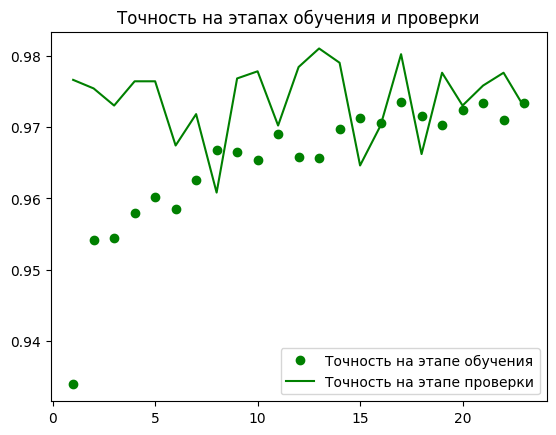

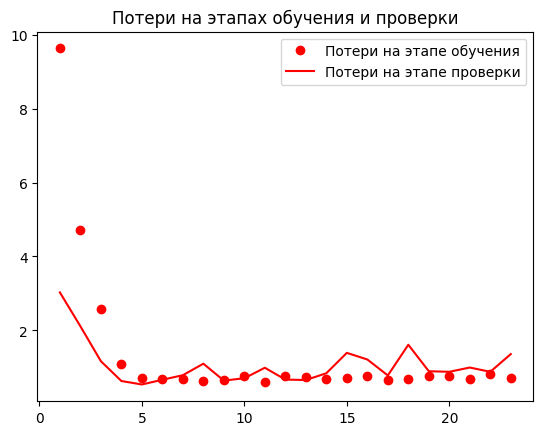

In [9]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'go', label='Точность на этапе обучения')
plt.plot(epochs, val_accuracy, 'g', label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.legend()
plt.show()

## Дообучение с заморозкой определенных весов

In [10]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
	layer.trainable = False

model.compile(
	loss='binary_crossentropy',
	optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),  # Низкая скорость обучения
	metrics=['accuracy']
)

history = model.fit(
  train_dataset,
	epochs=30,
	validation_data=validation_dataset,
	callbacks=callbacks
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 205ms/step - accuracy: 0.9739 - loss: 0.5983 - val_accuracy: 0.9788 - val_loss: 0.6309
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - accuracy: 0.9765 - loss: 0.3386 - val_accuracy: 0.9682 - val_loss: 0.7384
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 210ms/step - accuracy: 0.9771 - loss: 0.2186 - val_accuracy: 0.9770 - val_loss: 0.4501
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 208ms/step - accuracy: 0.9793 - loss: 0.1695 - val_accuracy: 0.9800 - val_loss: 0.3173
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 64s 204ms/step - accuracy: 0.9782 - loss: 0.1368 - val_accuracy: 0.9766 - val_loss: 0.3190
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 210ms/step - accuracy: 0.9787 - loss: 0.1258 - val_accuracy: 0.9782 - val_loss: 0.2764
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 210ms/step - accuracy: 0.9837 - loss: 0.1144 - val_accuracy: 0.9806 - val_loss: 0.2499
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - accuracy: 0.9821 - loss: 0

## Визуализация дообучения с заморозкой параметров

Построим графики изменения потерь и точности в процессе обучения модели.

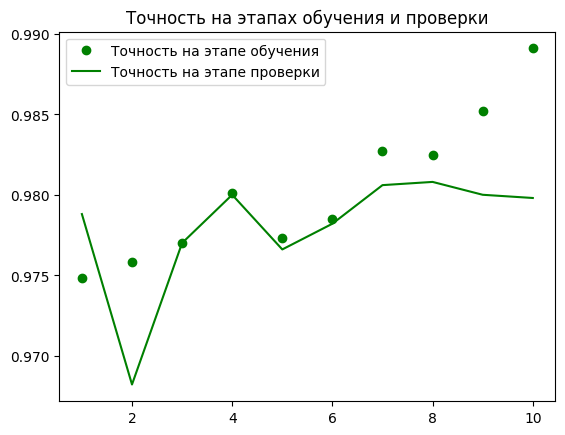

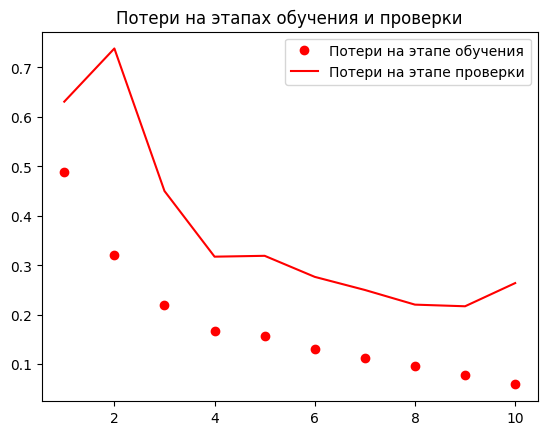

In [11]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.clf()
plt.plot(epochs, accuracy, 'go', label='Точность на этапе обучения')
plt.plot(epochs, val_accuracy, 'g', label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.legend()
plt.show()

## Тестирование модели

In [13]:
test_model = keras.models.load_model('/content/dogsvscats.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.9828 - loss: 0.2033
Test accuracy: 0.981
